## Recipe to evaluate model SSH with satellite image product 



**This recipe will show a simple example onto how to evaluate the model SSH over a satellite data. In this example, the satellite product chosen is from [Copernicus](https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/description), but the principles could be applied to any dataset. Examples for the timemean and seasonal cycle will be given**

<br>

-------------
Clarification!

The results presented in this recipe are not indicative of the model's reliability. The time-series data used is limited, and the primary objective is to demonstrate the methodology for performing this analysis with your own data.

-------------
<br>

Steps:
- Read model and satellite data
- Interpolate the higher-resolution data to the coarser to get the same points and same area
- Calculate the time-mean
- Check the differences
- Calculate the seasonality and compare
- Calculate RMSE


It assumes:
- You have in hands the satellite products and the roms output. You can donwload Copernicus dataset using our [Real-time script](https://github.com/UNSW-oceanography/ACCESS-NRI-SEACOFS/blob/main/Real-time/RT_download_copernicus.py).


Fernando Sobral - 6th Mar 2025


In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.interpolate import griddata

In [2]:
# Reading the data. Adjust the path according to where your data is and its name.
# Copernicus has other variables in the ncfile.

roms_meanSSH = xr.open_dataset('data/roms_ssh/output_zeta_average.nc').zeta.isel(ocean_time=0)
roms_all = xr.open_dataset('data/roms_ssh/roms_ssh_oneyear.nc').zeta - roms_meanSSH

copernicus = xr.open_dataset('data/copernicus_ssh/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_multi-vars_142.06E-169.94E_44.94S-15.06S_2009-01-01-2010-12-31.nc')


In [3]:
# Selecting the same TIME from roms in satellite

sat_ssh = copernicus.reindex(time=roms_all.ocean_time.values, method=None).dropna(dim='time', how='all').sla

# And using Copernicus to remove the dates in ROMS that are not in Copernicus
roms_ssh = roms_all.reindex(ocean_time=sat_ssh.time.values, method=None).dropna(dim='ocean_time', how='all')

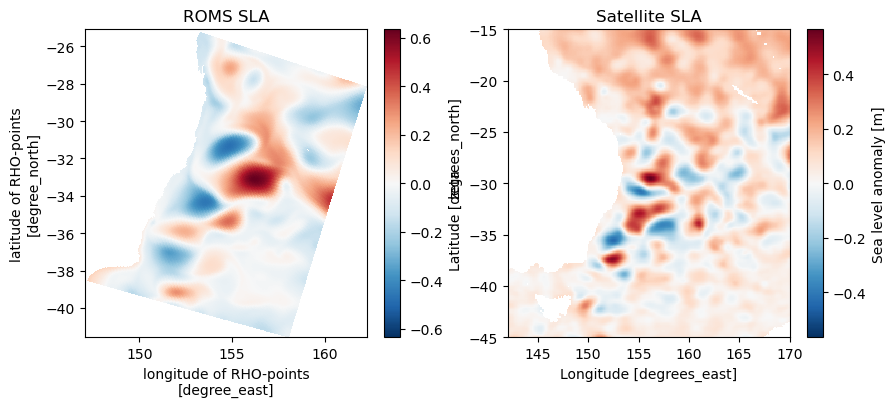

In [4]:
# Checking one day for our SSH roms and satellite data

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

roms_ssh.isel(ocean_time=0).plot(ax=ax[0], x='lon_rho', y='lat_rho')
ax[0].set_title('ROMS SLA')

sat_ssh.isel(time=0).plot(ax=ax[1], x='longitude', y='latitude')
ax[1].set_title('Satellite SLA');

In [5]:
# Checking grid resolution (satellite is 0.125° and ROMS is variable from 0.02 to 0.06)

lon_roms = roms_ssh.lon_rho.values
lat_roms = roms_ssh.lat_rho.values

lon_sat = sat_ssh.longitude.values
lat_sat = sat_ssh.latitude.values

print('ROMS grid resolution:', lon_roms[0, 1] - lon_roms[0, 0], lat_roms[1, 0] - lat_roms[0, 0])
print('Satellite grid resolution:', lon_sat[1] - lon_sat[0], lat_sat[1] - lat_sat[0])

ROMS grid resolution: 0.03247192783149444 0.04234901231472321
Satellite grid resolution: 0.125 0.125


In [6]:
# Interpolate ROMS grid to Satellite grid (higher resolution into coarser resolution)
LON, LAT = np.meshgrid(lon_sat, lat_sat)

# Flatten the arrays for interpolation
points = np.array([lon_roms.ravel(), lat_roms.ravel()]).T

# List to store regridded time steps
regridded_list = []

for TT in roms_ssh.ocean_time.values:
    print(TT)

    # Extract values for the current time step
    values = roms_ssh.sel(ocean_time=TT).values.ravel()

    # Interpolate onto Satellite grid
    interpolated = griddata(points, values, (LON, LAT), method='linear')

    # Convert interpolated result to a DataArray with correct dimensions
    interpolated_da = xr.DataArray(
        interpolated,
        dims=("latitude", "longitude"),
        coords={"latitude": lat_sat, "longitude": lon_sat, "time": TT},
    )

    # Append to list
    regridded_list.append(interpolated_da)

# Concatenate along time dimension
roms_regrided = xr.concat(regridded_list, dim="time")

2009-01-01T00:00:00.000000000
2009-01-02T00:00:00.000000000
2009-01-03T00:00:00.000000000
2009-01-04T00:00:00.000000000
2009-01-05T00:00:00.000000000
2009-01-06T00:00:00.000000000
2009-01-07T00:00:00.000000000
2009-01-08T00:00:00.000000000
2009-01-09T00:00:00.000000000
2009-01-10T00:00:00.000000000
2009-01-11T00:00:00.000000000
2009-01-12T00:00:00.000000000
2009-01-13T00:00:00.000000000
2009-01-14T00:00:00.000000000
2009-01-15T00:00:00.000000000
2009-01-16T00:00:00.000000000
2009-01-17T00:00:00.000000000
2009-01-18T00:00:00.000000000
2009-01-19T00:00:00.000000000
2009-01-20T00:00:00.000000000
2009-01-21T00:00:00.000000000
2009-01-22T00:00:00.000000000
2009-01-23T00:00:00.000000000
2009-01-24T00:00:00.000000000
2009-01-25T00:00:00.000000000
2009-01-26T00:00:00.000000000
2009-01-27T00:00:00.000000000
2009-01-28T00:00:00.000000000
2009-01-29T00:00:00.000000000
2009-01-30T00:00:00.000000000
2009-01-31T00:00:00.000000000
2009-02-01T00:00:00.000000000
2009-02-02T00:00:00.000000000
2009-02-03

In [7]:
# Let's mask satellite data to match only the part of the roms data.
# Doing for roms as well, to remove the big nan area created by the interpolation.

sat_masked = sat_ssh.where(~np.isnan(roms_regrided), drop=True)
roms_masked = roms_regrided.where(~np.isnan(roms_regrided), drop=True)

In [8]:
# Calculating the RMS and STD

roms_rms = np.sqrt((roms_masked**2).mean('time'))
sat_rms = np.sqrt((sat_masked**2).mean('time'))

roms_std = roms_masked.std('time')
sat_std = sat_masked.std('time')

In [9]:
# Calculating the difference from the time-mean

diff_ = sat_rms - roms_rms

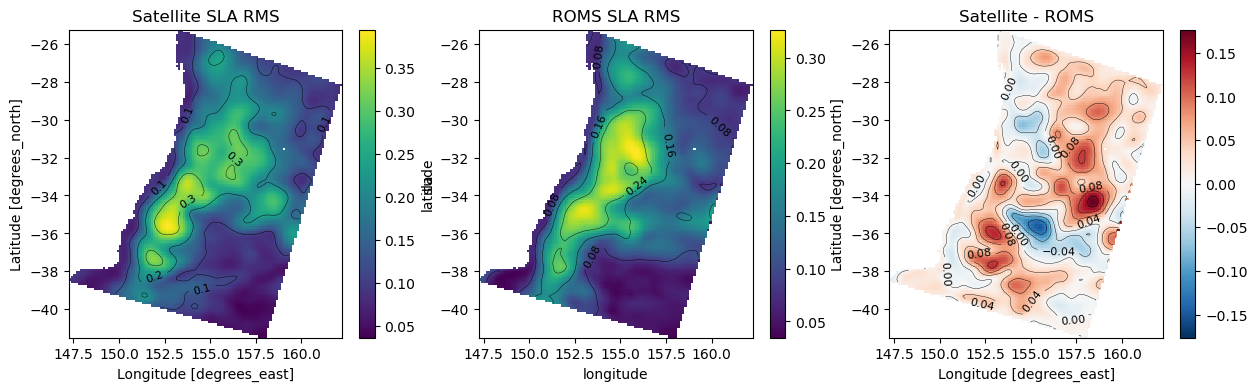

In [10]:
# Checking the timemean comparison

fig, ax = plt.subplots(ncols=3, figsize=(15, 4))

sat_rms.plot(ax=ax[0])
cnt = sat_std.plot.contour(ax=ax[0], levels=5, colors=['k'], linewidths=0.3)
plt.clabel(cnt, inline=True, fontsize=8)
ax[0].set_title('Satellite SLA RMS');

roms_rms.plot(ax=ax[1])
cnt = roms_std.plot.contour(ax=ax[1], levels=5, colors=['k'], linewidths=0.3)
plt.clabel(cnt, inline=True, fontsize=8)
ax[1].set_title('ROMS SLA RMS')

diff_.plot(ax=ax[2])
cnt = diff_.plot.contour(ax=ax[2], levels=10, colors=['k'], linewidths=0.3)
plt.clabel(cnt, inline=True, fontsize=8)
ax[2].set_title('Satellite - ROMS');



<br>

### **Doing the seasonal analysis**

In [11]:
# Grouping the data in seasons

roms_seasons = roms_masked.groupby('time.season')
sat_seasons = sat_masked.groupby('time.season')

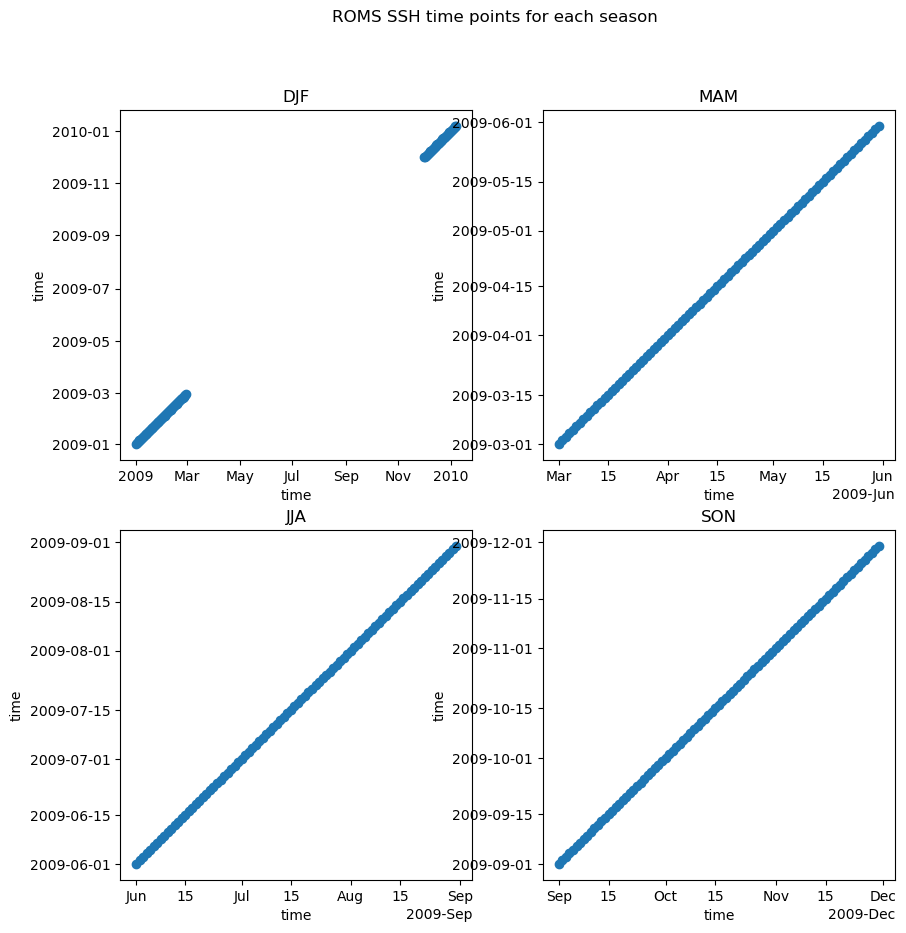

In [12]:
# Plotting the time points for DJF season without connecting the markers
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

roms_seasons['DJF'].time.plot(ax=ax[0, 0], marker='o', linestyle='None'); ax[0, 0].set_title('DJF')
roms_seasons['MAM'].time.plot(ax=ax[0, 1], marker='o', linestyle='None'); ax[0, 1].set_title('MAM')
roms_seasons['JJA'].time.plot(ax=ax[1, 0], marker='o', linestyle='None'); ax[1, 0].set_title('JJA')
roms_seasons['SON'].time.plot(ax=ax[1, 1], marker='o', linestyle='None'); ax[1, 1].set_title('SON');
fig.suptitle('ROMS SSH time points for each season');

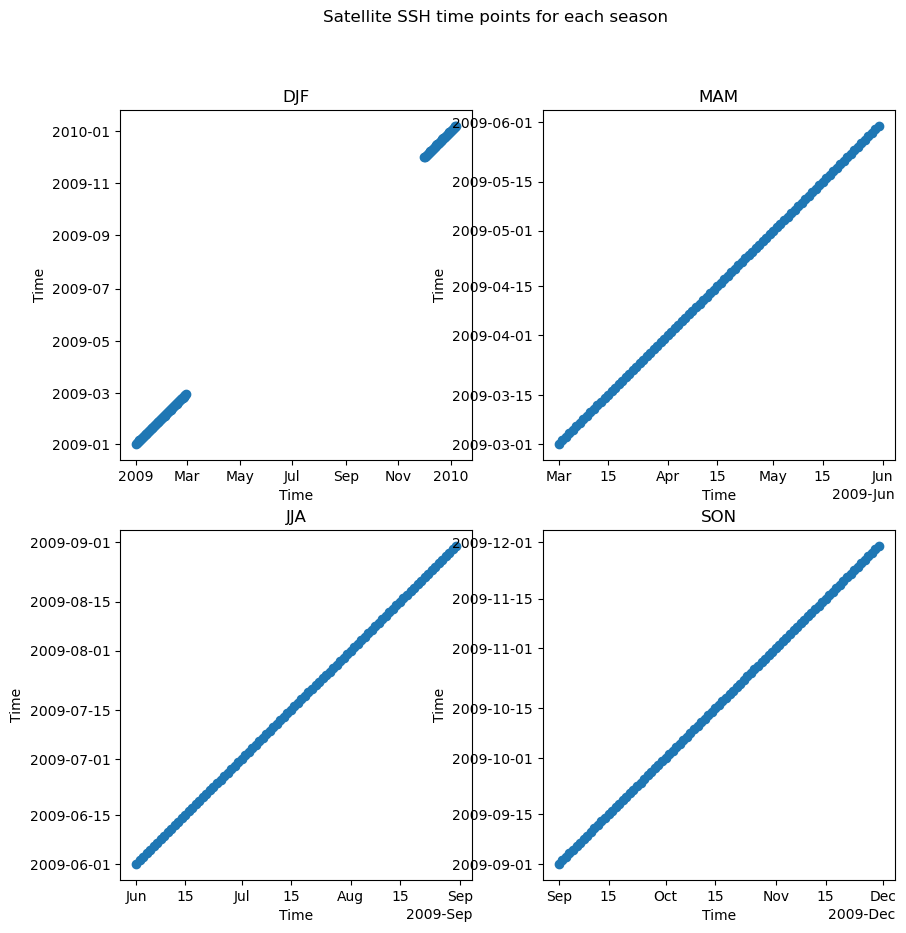

In [13]:
# Plotting the time points for DJF season without connecting the markers
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

sat_seasons['DJF'].time.plot(ax=ax[0, 0], marker='o', linestyle='None'); ax[0, 0].set_title('DJF')
sat_seasons['MAM'].time.plot(ax=ax[0, 1], marker='o', linestyle='None'); ax[0, 1].set_title('MAM')
sat_seasons['JJA'].time.plot(ax=ax[1, 0], marker='o', linestyle='None'); ax[1, 0].set_title('JJA')
sat_seasons['SON'].time.plot(ax=ax[1, 1], marker='o', linestyle='None'); ax[1, 1].set_title('SON');
fig.suptitle('Satellite SSH time points for each season');

In [14]:
# Now we know the our seasonal data is correct, let's calculate the seasonal rms

roms_seasons_rms = roms_seasons.map(lambda x: np.sqrt((x**2).mean('time')))
sat_seasons_rms = sat_seasons.map(lambda x: np.sqrt((x**2).mean('time')))

# # Calculating the STD
roms_seasons_std = roms_seasons.std('time')
sat_seasons_std = sat_seasons.std('time')

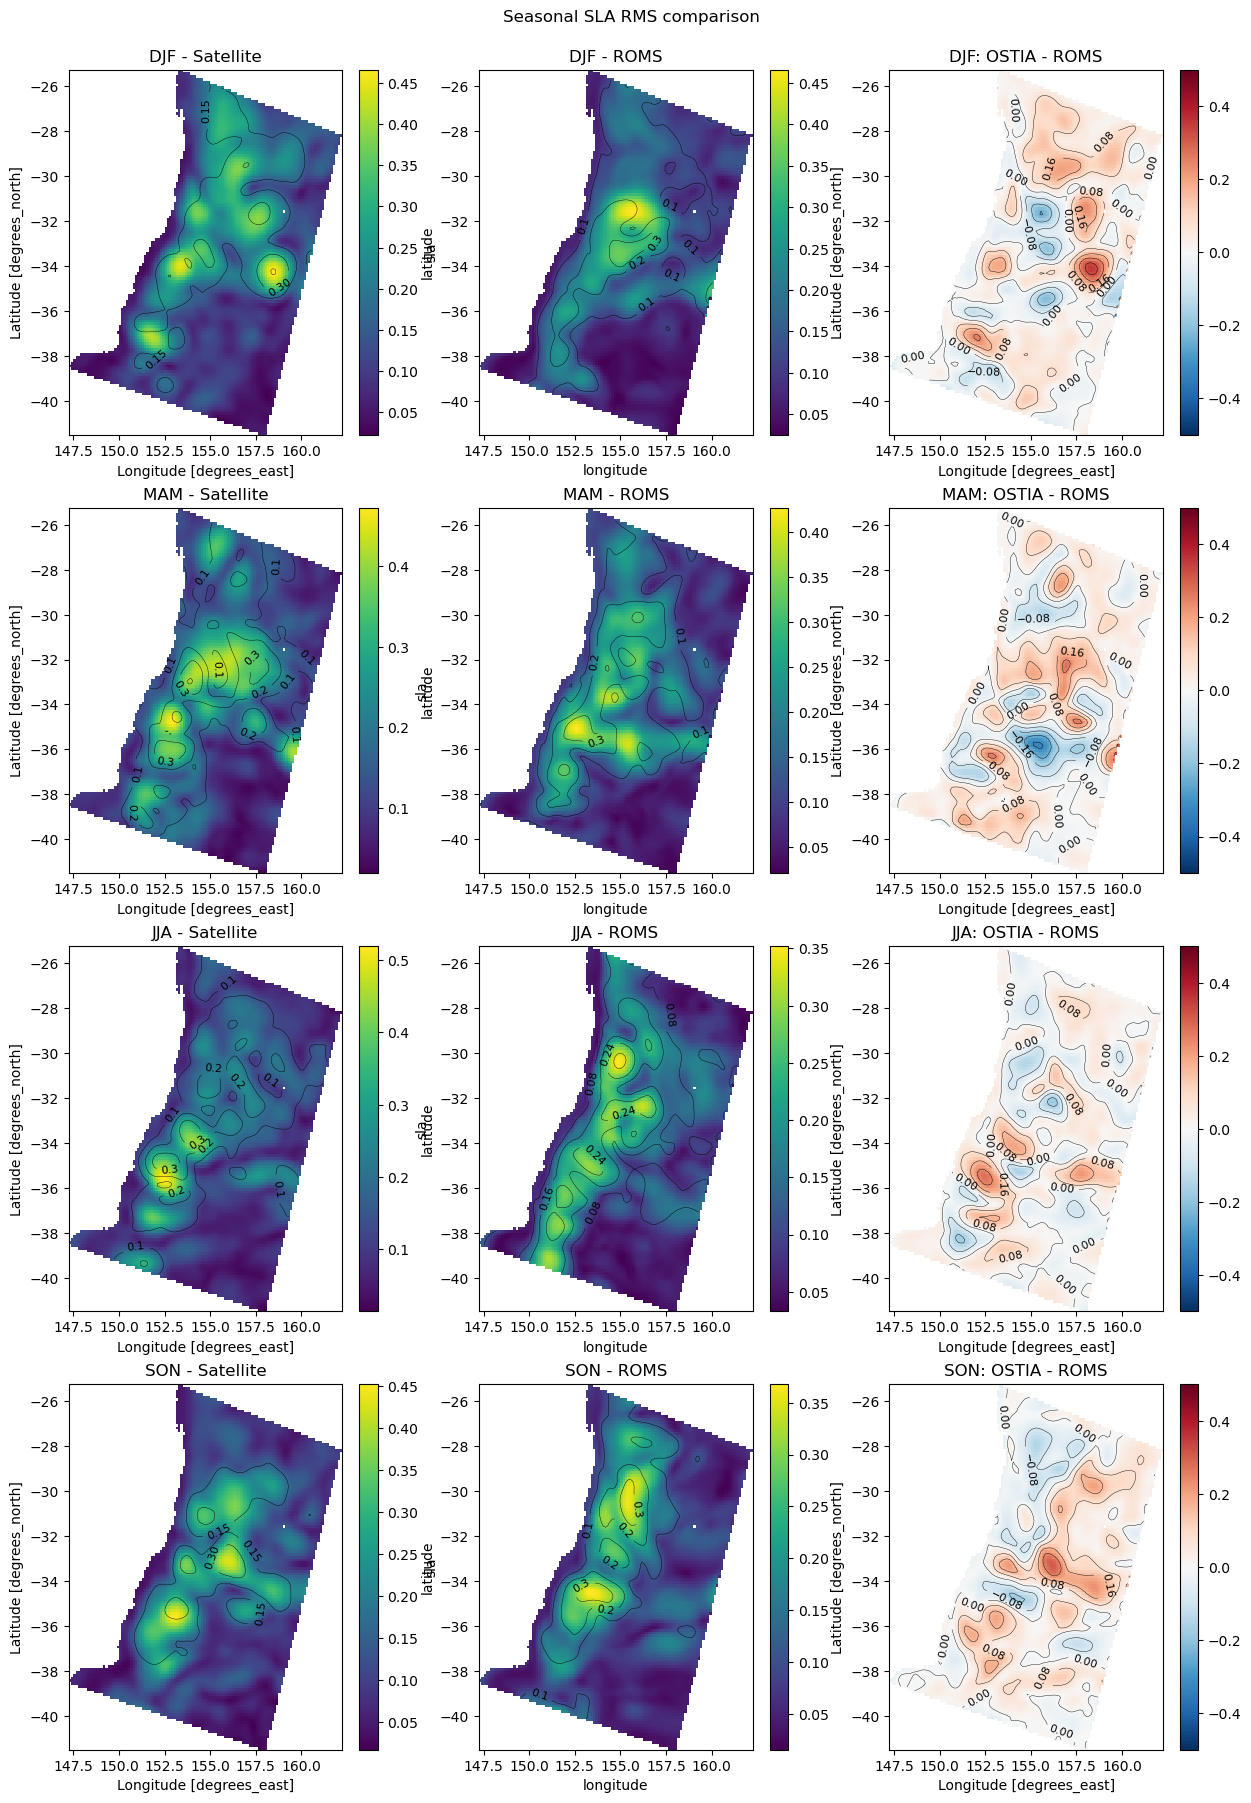

In [19]:
# Plotting each seasonal mean and calculating the difference between Satellite and ROMS
# Isolines in the first two columns are STD. Last column is the difference between Satellite and ROMS

fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(15, 20))

for enu, SS in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
   
    # Satellite
    sat_seasons_rms.sel(season=SS).plot(ax=ax[enu, 0])
    cnt = sat_seasons_std.sel(season=SS).plot.contour(ax=ax[enu, 0], levels=5, colors=['k'], linewidths=0.3)
    plt.clabel(cnt, inline=True, fontsize=8)

    # ROMS
    roms_seasons_rms.sel(season=SS).plot(ax=ax[enu, 1])
    cnt = roms_seasons_std.sel(season=SS).plot.contour(ax=ax[enu, 1], levels=5, colors=['k'], linewidths=0.3)
    plt.clabel(cnt, inline=True, fontsize=8)

    # Calculating the difference
    diff = sat_seasons_rms.sel(season=SS) - roms_seasons_rms.sel(season=SS)
    diff.plot(ax=ax[enu, 2], vmin=-0.5, vmax=0.5, cmap='RdBu_r')
    cnt = diff.plot.contour(ax=ax[enu, 2], levels=10, colors=['k'], linewidths=0.3)
    plt.clabel(cnt, inline=True, fontsize=8)

    # Adding titles
    ax[enu, 0].set_title(SS + ' - Satellite')
    ax[enu, 1].set_title(SS + ' - ROMS')
    ax[enu, 2].set_title(SS + ': OSTIA - ROMS')
    
fig.suptitle('Seasonal SLA RMS comparison');
fig.subplots_adjust(top=0.95)


In [16]:
# Also, we can also calculate a spatial mean and plot the timeseries together

roms_spatial_mean = np.sqrt((roms_masked**2).mean(['latitude', 'longitude']))
sat_spatial_mean = np.sqrt((sat_masked**2).mean(['latitude', 'longitude']))

In [17]:
# Calculating the RMSE for the spatial mean

rmse = ((sat_spatial_mean - roms_spatial_mean)**2).mean() ** 0.5

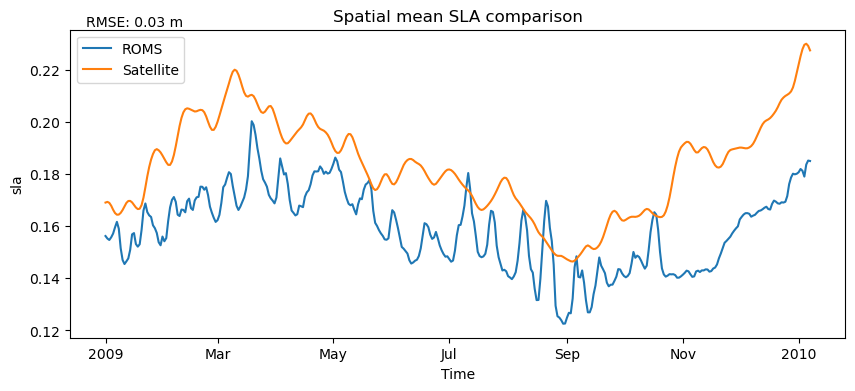

In [20]:
# Plotting the time series

fig, ax = plt.subplots(figsize=(10, 4))
roms_spatial_mean.plot(ax=ax, label='ROMS')
sat_spatial_mean.plot(ax=ax, label='Satellite')
ax.legend()
annotate_str = 'RMSE: {:.2f} m'.format(rmse.values)
ax.annotate(annotate_str, xy=(0.02, 1.01), xycoords='axes fraction')
ax.set_title('Spatial mean SLA comparison');
